# Using AR Models to Predict Stock Price

## 1. Stationarity

To build an autoregressive model, which is one created by regressing a time series on its past values, we need to ensure covariance stationarity of a time series.

But once transformations are done to induced stationarity for time series models, how do we get predicted numbers back into the original series instead of the stationarity-indced time series? This notebook seeks to explore this simple concept on the SPY time series

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Transformation Steps

(1) Normalize ($v_t \rightarrow n_t): n_t = \frac{v_t - \mu}{\sigma}$

(2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$

(3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$

Putting it all together...</br>
$d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$

------------------------------------------------------------

### Original Series: $v_t$

In [2]:
def adf(S, cutoff=0.05):
    """This function discerns if a series is stationary of non-stationary by ADF"""
    pvalue = adfuller(S)[1]

    if pvalue < cutoff:
        print(f'p-value = {pvalue}.\n{S.name} is likely stationary.')
    else:
        print(f'p-value = {pvalue}.\n{S.name} is likely non-stationary.')

In [3]:
 # Get historical pricing data
def getHistoricalData(tickers, start, end):
    s_year, s_month, s_day = start
    e_year, e_month, e_day = end
    # Getting data from Yahoo Finance
    df = yf.download(tickers, datetime(s_year, s_month, s_day), datetime(e_year, e_month, e_day), group_by='tickers')
    # Grabbing the adj close data
    if (df.columns.nlevels >  1):
        df = df.iloc[:, df.columns.get_level_values(1)=='Adj Close']
        df.columns = df.columns.droplevel(1)
    else:
        df = df[['Adj Close']]
        
    df.columns = [x + ' Adj Close' for x in tickers]

    return df

In [4]:
start = [2020,1,1]
end = [2021,1,1]
stock_data = getHistoricalData(['SPY'], start, end)
stock_data

[*********************100%***********************]  1 of 1 completed


,SPY Adj Close
Date,
2019-12-31,311.803223
2020-01-02,314.719238
2020-01-03,312.336090
2020-01-06,313.527649
2020-01-07,312.646088
...,...
2020-12-24,364.145996
2020-12-28,367.274323
2020-12-29,366.573639


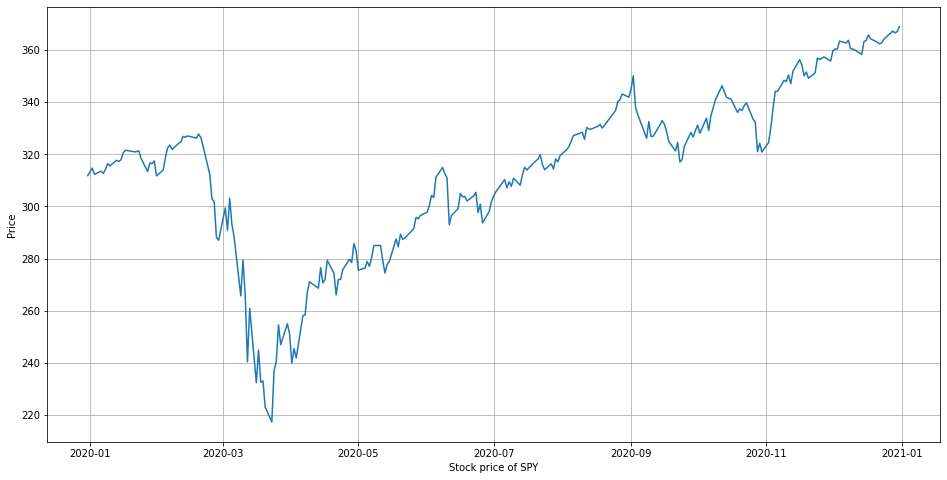

In [5]:
plt.figure(figsize=(16,8))
plt.plot(stock_data)
plt.xlabel('Stock price of SPY')
plt.ylabel('Price')
plt.grid()
plt.show;

### 1. Normalize

Normalize the time series to get them to a more easy to manage space so that the next step (exponentiate) won't overflow

In [6]:
norm_ts = (stock_data - stock_data.mean())/stock_data.std()
norm_ts

,SPY Adj Close
Date,
2019-12-31,-0.063997
2020-01-02,0.026788
2020-01-03,-0.047407
2020-01-06,-0.010310
2020-01-07,-0.037756
...,...
2020-12-24,1.565614
2020-12-28,1.663010
2020-12-29,1.641195


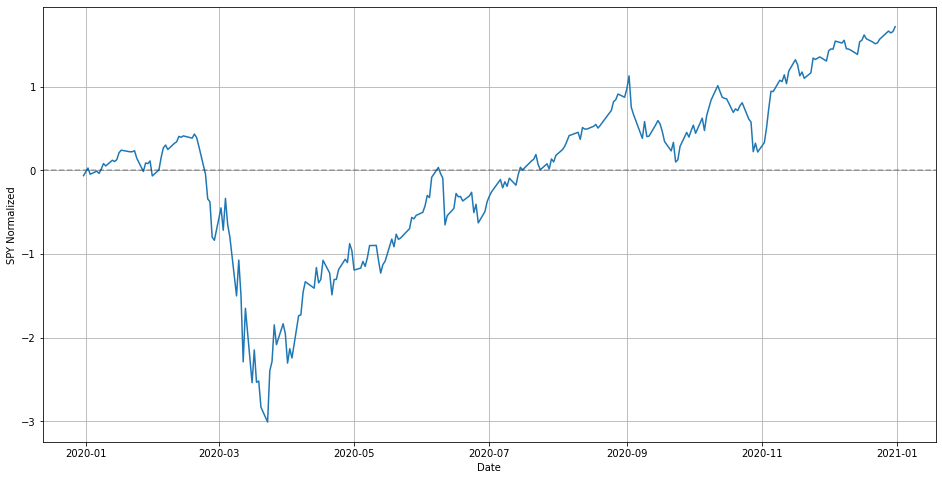

In [7]:
plt.figure(figsize=(16,8))
plt.plot(norm_ts)
plt.xlabel('Date')
plt.ylabel('SPY Normalized')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.grid()
plt.show();

In [8]:
norm_ts.name = 'Norm. SPY'
adf(norm_ts)

p-value = 0.6889380599197454.
Norm. SPY is likely non-stationary.


### 2. Exponentiate

"Straighten" it out. Look more like a linear growth

In [9]:
exp_ts = np.exp(norm_ts)

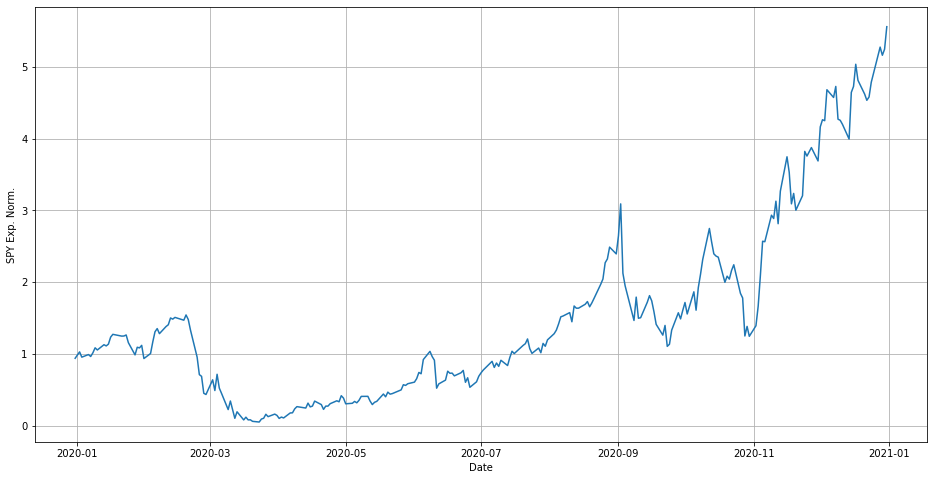

In [10]:
plt.figure(figsize=(16,8))
plt.plot(exp_ts)
plt.xlabel('Date')
plt.ylabel('SPY Exp. Norm.')
plt.grid()
plt.show();

In [11]:
exp_ts.name = 'Exp. Norm. SPY'
adf(exp_ts)

p-value = 0.9981527240109817.
Exp. Norm. SPY is likely non-stationary.


### 3. First Difference

Since the series now looks more linear, we take first difference

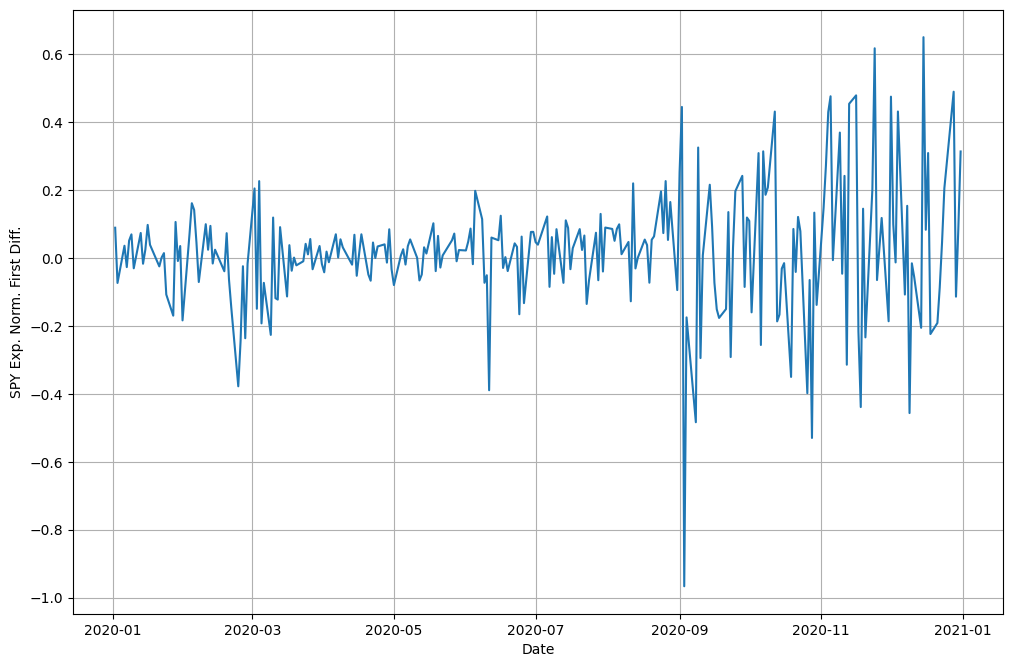

In [12]:
diff_ts = exp_ts.diff()[1:]

plt.figure(figsize=(12,8),dpi=100)
plt.plot(diff_ts)
plt.xlabel('Date')
plt.ylabel('SPY Exp. Norm. First Diff.')
plt.grid()
plt.show();

In [13]:
diff_ts.name = 'First difference. Exp. Norm. SPY'
adf(diff_ts)

p-value = 1.0704658309420532e-06.
First difference. Exp. Norm. SPY is likely stationary.


In [14]:
diff_ts

,SPY Adj Close
Date,
2020-01-02,0.089143
2020-01-03,-0.073452
2020-01-06,0.036044
2020-01-07,-0.026795
2020-01-08,0.051273
...,...
2020-12-24,0.205706
2020-12-28,0.489551
2020-12-29,-0.113830


## 2. Fit AR Model and Undo Stationary Transformations

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


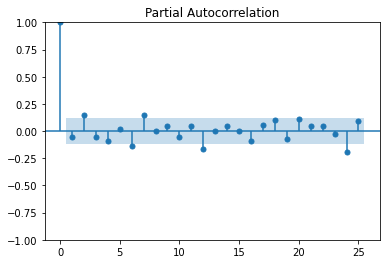

In [15]:
plot_pacf(diff_ts)
plt.show();

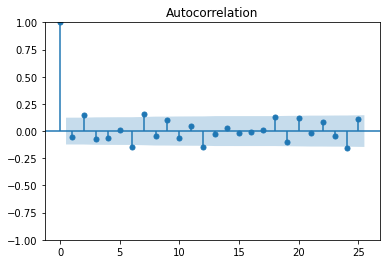

In [16]:
plot_acf(diff_ts)
plt.show()

### Create the model

In [31]:
# Creating the ARMA model
model = ARIMA(diff_ts, order=(12,0,0))

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [32]:
model_fit = model.fit()

### Predicting 3D forwards

In [33]:
pred = model_fit.forecast(21)[1:]

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [34]:
index = pd.date_range(datetime(2021, 1, 1), datetime(2021, 1, 28), freq='B')
pred.index = index

pred_df = pd.DataFrame(pred)
pred_df.columns = diff_ts.columns

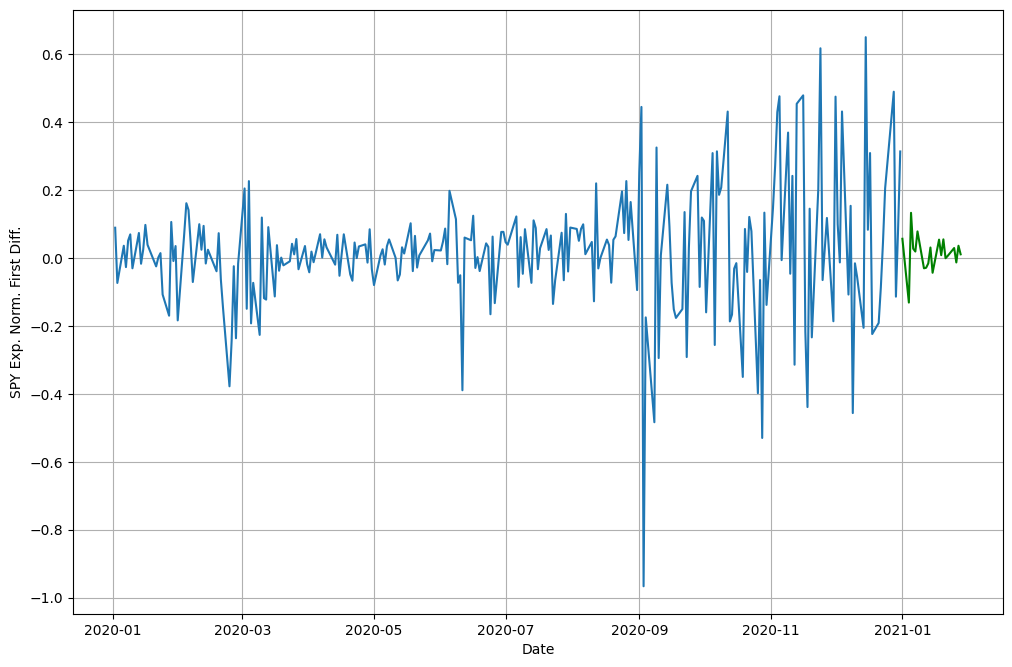

In [35]:
plt.figure(figsize=(12,8),dpi=100)
plt.plot(diff_ts)
plt.xlabel('Date')
plt.ylabel('SPY Exp. Norm. First Diff.')
plt.plot(pred_df, color='g')
plt.grid()
plt.show();

### Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)

$\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [36]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    # using first pred to predict other values
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

orig_preds = undo_transformations(pred_df.values, stock_data, stock_data.mean(), stock_data.std())
orig_preds = pd.DataFrame(orig_preds)
orig_preds.index = index

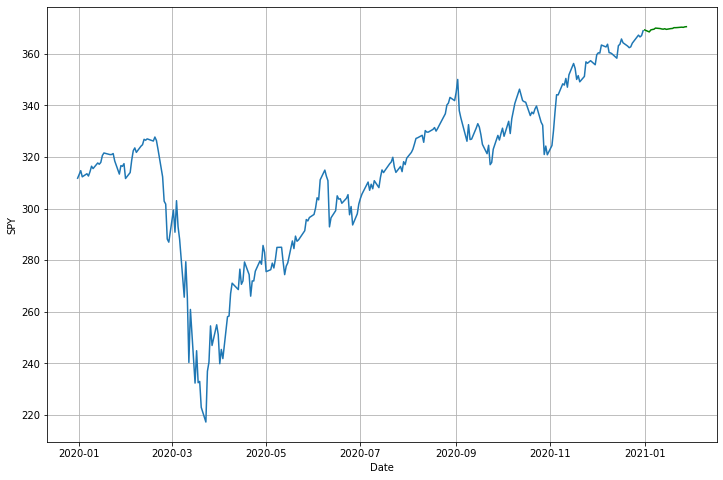

In [37]:
plt.figure(figsize=(12,8))
plt.plot(stock_data)
plt.xlabel('Date')
plt.ylabel('SPY')
plt.plot(orig_preds, color='g')
plt.grid()
plt.show();

In [38]:
start = [2020,1,1]
end = [2021,1,29]
actual_stock_data = getHistoricalData(['SPY'], start, end)

[*********************100%***********************]  1 of 1 completed


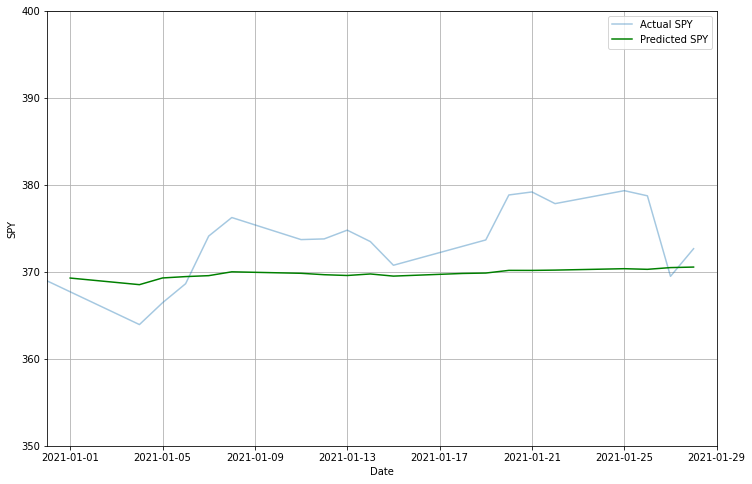

In [39]:
plt.figure(figsize=(12,8))
plt.plot(actual_stock_data, alpha=0.4)
plt.xlabel('Date')
plt.ylabel('SPY')
plt.plot(orig_preds, color='g')
plt.legend(['Actual SPY', 'Predicted SPY'])
plt.grid()
plt.xlim(datetime(2020,12,31), datetime(2021,1,29))
plt.ylim(350,400)
plt.show();

### Next Steps:
1. Analyse residuals in actual and predicted